# Maximum likelihood estimation with Tensorflow Bijectors
This notebook shows how to train model using Maximum likelihood  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tfd = tf.contrib.distributions
tfb = tfd.bijectors
layers = tf.contrib.layers
%matplotlib inline

%load_ext autoreload
%autoreload 2

tf.__version__

'1.8.0'

# Define toy problem

In [2]:
tf.set_random_seed(0)
sess = tf.InteractiveSession()

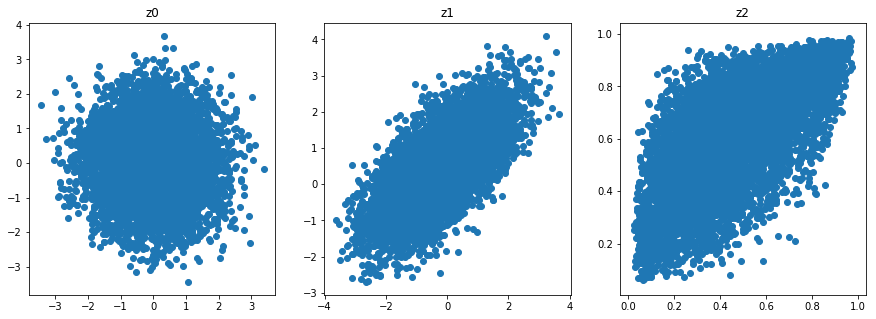

In [4]:
# a sample of N(0, 1)
z0 = np.random.randn(*[32 * 200, 2])
# first transform
z1 = z0 @ np.array([[0.5, 1.0], [1, .3]]) + np.array([-0.2, .5])
# sigmoid transform
z2 = 1 / (1 + np.exp( - z1))

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("z0")
plt.scatter(*z0.T)
plt.subplot(132)
plt.title("z1")
plt.scatter(*z1.T)
plt.subplot(133)
plt.title("z2")
plt.scatter(*z2.T)

# Define dataset iterator over samples from toy model

Here we create tensorflow dataset iterator over generated data

In [6]:
import utils

dataset = utils.numpy_array_to_dataset(z2, batch_size=64)
data_iterator = dataset.make_one_shot_iterator()
z2_samples = data_iterator.get_next()
z2_samples

<tf.Tensor 'IteratorGetNext:0' shape=(?, 2) dtype=float32>

In [8]:
z2_samples.eval().shape

(64, 2)

# Define toy model 

## Some utils
I had some problems with tfb.Sigmoid when used together with Affine operation, so I decided to create my own which calls reduce_sum in `_inverse_log_det_jacobian`. My tf version was 1.8.0.

In [9]:
class Sigmoid(tfb.Sigmoid):

    def _inverse_log_det_jacobian(self, y):
        res =  super()._inverse_log_det_jacobian(y)
        return tf.cast(tf.reduce_sum(res, axis=-1), dtype=tf.float32)

    def _forward_log_det_jacobian(self, x):
        # We are not going to use it anyway in this demo problem
        res =  super()._forward_log_det_jacobian(y)
        return tf.cast(tf.reduce_sum(res, axis=-1), dtype=tf.float32)
    
    
class AffineScalar(tfb.AffineScalar):    
    def _forward_log_det_jacobian(self, x):        
        res =  super()._forward_log_det_jacobian(x)
        return tf.reduce_sum(res, axis=-1)

In [10]:
points = tf.to_float([[0.5, 0.5], [0.2, 0.2], [0.5, 0.5]])

### Testing Bijectors shapes

In [11]:
sig = Sigmoid()
sig.inverse_log_det_jacobian(points), sig.forward(points), sig.inverse(points)

(<tf.Tensor 'sigmoid/inverse_log_det_jacobian/Sum:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'sigmoid_1/forward/Sigmoid:0' shape=(3, 2) dtype=float32>,
 <tf.Tensor 'sigmoid_2/inverse/sub:0' shape=(3, 2) dtype=float32>)

In [12]:
asc = AffineScalar(scale=tf.constant([1.0, 1.0]))

asc.inverse_log_det_jacobian(points), asc.forward(points), asc.inverse(points)

(<tf.Tensor 'affine_scalar_1/inverse_log_det_jacobian/Neg:0' shape=(3,) dtype=float32>,
 <tf.Tensor 'affine_scalar_2/forward/mul:0' shape=(3, 2) dtype=float32>,
 <tf.Tensor 'affine_scalar_1/inverse_log_det_jacobian/truediv:0' shape=(3, 2) dtype=float32>)

In [13]:
aff = tfb.Affine(
    scale_tril=tf.constant([[2.0, 1.0], [1.0, 1.0]]),
    shift=tf.constant([0.0, 0.0])
)
aff.inverse_log_det_jacobian(points), aff.forward(points), aff.inverse(points)

(<tf.Tensor 'affine_1/inverse_log_det_jacobian/Neg:0' shape=() dtype=float32>,
 <tf.Tensor 'affine_2/forward/add:0' shape=(3, 2) dtype=float32>,
 <tf.Tensor 'affine_3/inverse/DistributionShape_1/undo_make_batch_of_event_sample_matrices/Reshape:0' shape=(3, 2) dtype=float32>)

In [14]:
with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
    base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))
    bijectors = [
        tfb.Affine(scale_perturb_factor=tf.get_variable('V', [2, 2]),
            scale_tril=tf.get_variable("tril", shape=[2, 2]),
            shift=tf.get_variable("shift", shape=[2])
        ),
        Sigmoid()
    ]

    dist = tfd.TransformedDistribution(
        distribution=base_dist,
        bijector=tfb.Chain(list(reversed(bijectors))),
    )

## Test samples from model

In [15]:
samples_tf = dist.sample(512*10)
sess.run(tf.global_variables_initializer())

In [16]:
samples_tf

<tf.Tensor 'chain_of_sigmoid_of_affineMultivariateNormalDiag/sample/chain_of_sigmoid_of_affine/forward/sigmoid/forward/Sigmoid:0' shape=(5120, 2) dtype=float32>

Plotting initial distribution

(5.7797635e-05, 0.9996076)

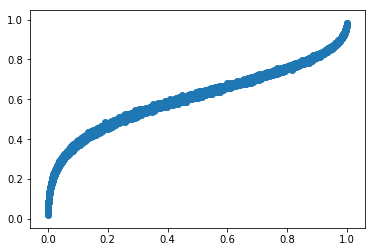

In [17]:
x_samples_np = samples_tf.eval()
plt.scatter(*x_samples_np.T)
x_samples_np.min(), x_samples_np.max()

# Plot logP in the z2 domain -> [0, 1]

In [18]:
x = np.linspace(0.01, 0.99, 50)
y = np.linspace(0.01, 0.99, 50)
X, Y = np.meshgrid(x, y)
points = np.vstack([X, Y]).reshape([2, -1]).T.astype(np.float32)
log_probs_tf = dist.log_prob(points)
log_probs_tf

<tf.Tensor 'chain_of_sigmoid_of_affineMultivariateNormalDiag_1/log_prob/add:0' shape=(2500,) dtype=float32>

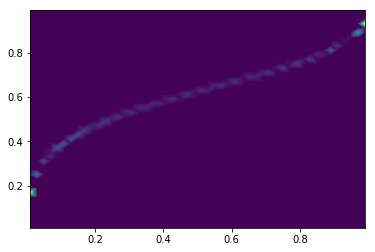

In [19]:
log_probs_np = sess.run(log_probs_tf)
plt.tricontourf(points[:, 0], points[:, 1], np.exp(log_probs_np), 100)

In [20]:
z2_samples

<tf.Tensor 'IteratorGetNext:0' shape=(?, 2) dtype=float32>

## Define the loss function and train the model
A loss function is the MLE:
$$L = - \log p(z)$$

In [21]:
loss = -tf.reduce_mean(dist.log_prob(z2_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

In [22]:
sess.run(tf.global_variables_initializer())

0 11.156377


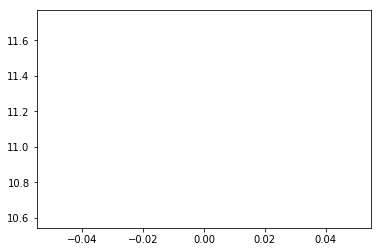

1000 -0.2875692


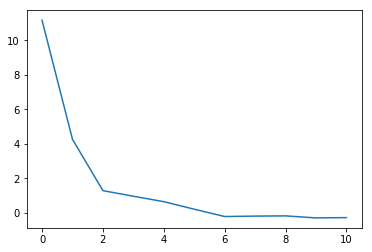

2000 -0.71127


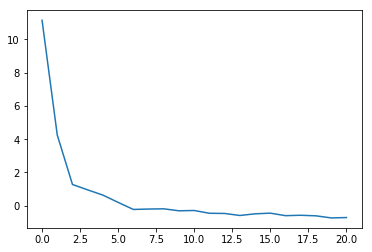

3000 -0.7356275


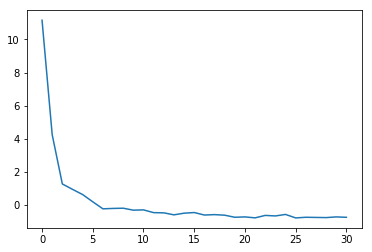

4000 -0.68640935


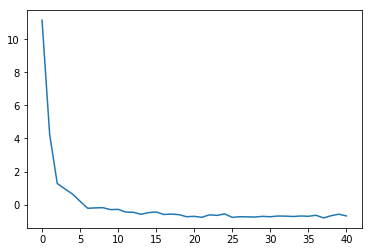

5000 -0.7070317


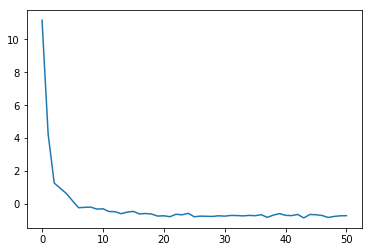

6000 -0.81863815


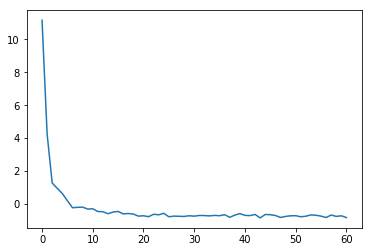

7000 -0.6684395


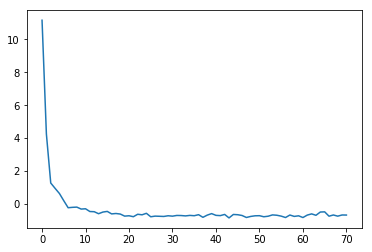

8000 -0.7254015


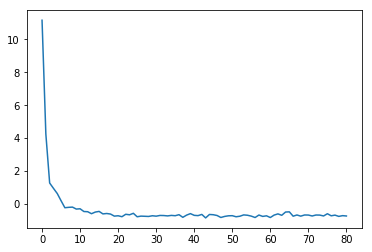

9000 -0.7872127


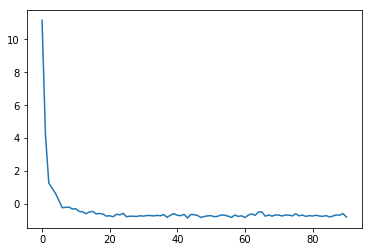

In [23]:
NUM_STEPS = 10000
global_step = []
np_losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])    
    if i % 100 == 0:
        global_step.append(i)
        np_losses.append(np_loss)
    if i % int(1e3) == 0:
        print(i, np_loss)
        plt.plot(np_losses)
        plt.show()

## Plot samples from trained model

(0.008869423, 0.9814293)

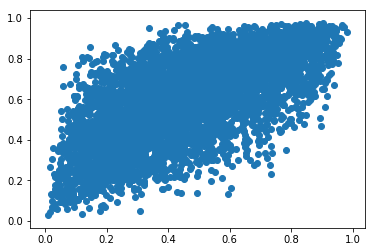

In [24]:
x_samples_np = sess.run(samples_tf)
plt.scatter(*x_samples_np.T)
x_samples_np.min(), x_samples_np.max()

## Plot the likelihood function as a function of z2 coordinates

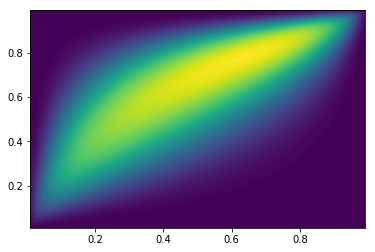

In [25]:
log_probs_np = sess.run(log_probs_tf)
plt.tricontourf(points[:, 0], points[:, 1], np.exp(log_probs_np), 100)

# Compute expected likelihood function

Here we compute log probs manually since we want to plot them after each transformation step. 

In [26]:
p0_z0 = tfd.MultivariateNormalDiag(np.zeros([2]).astype('float32'))
z0 = p0_z0.sample(32)

bijector1 = tfb.AffineLinearOperator(
    shift=tf.to_float(np.array([-0.2, .5]).astype('float32')), 
    scale=tf.linalg.LinearOperatorFullMatrix(np.array([[0.5, 1.0], [1, .3]]).astype('float32'))
)
z1 = bijector1.forward(z0)
log_p1 = bijector1.forward_log_det_jacobian(z0)

bijector2 = Sigmoid()
z2 = bijector2.forward(z1)
log_p2 = bijector2.forward_log_det_jacobian(z1)

log_p2_z2 = p0_z0.log_prob(z0) - log_p1 - log_p2

In [27]:
sampled_z0 = []
sampled_z1 = []
sampled_z2 = []
sampled_log_p = []
for i in range(500):
    z0_np, z1_np, z2_np, log_p2_np = sess.run([z0, z1, z2, log_p2_z2])
    sampled_z0.append(z0_np)
    sampled_z1.append(z1_np)
    sampled_z2.append(z2_np)
    sampled_log_p.append(log_p2_np)
    
    
sampled_z0 = np.concatenate(sampled_z0)
sampled_z1 = np.concatenate(sampled_z1)
sampled_z2 = np.concatenate(sampled_z2)
sampled_log_p = np.concatenate(sampled_log_p)

In [28]:
sampled_z0.shape

(16000, 2)

## Check samples

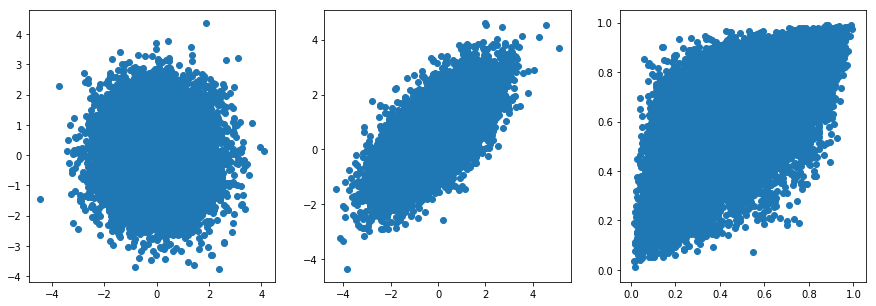

In [29]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(*sampled_z0.T)
plt.subplot(132)
plt.scatter(*sampled_z1.T)
plt.subplot(133)
plt.scatter(*sampled_z2.T)

# Compare model likelihood with expected one

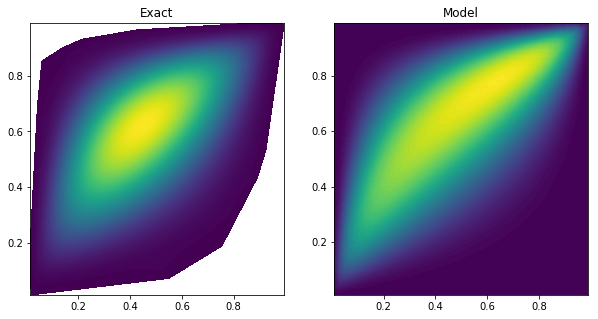

In [30]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Exact")
plt.tricontourf(sampled_z2[:, 0], sampled_z2[:, 1], np.exp(sampled_log_p), 200)
plt.subplot(122)
plt.title("Model")
plt.tricontourf(points[:, 0], points[:, 1], np.exp(log_probs_np), 100)